# Import

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import matplotlib.pyplot as plt
import missingno as mno
import numpy as np
import pandas as pd
import seaborn as sns

from customer_segmentation import CustomerStandardizer, CustomerSummary, Periodizer

%matplotlib inline
sns.set_style('white')

In [30]:
orders = pd.read_csv("csv/orders.csv").drop(
    ["index", "order_approved_at", "order_delivered_carrier_date"], axis=1
)
payments = pd.read_csv("csv/payments.csv").drop(
    ["index", "payment_installments", "payment_sequential", "payment_type"], axis=1
)
reviews = pd.read_csv("csv/reviews.csv").drop(
    [
        "index",
        "review_id",
        "review_answer_timestamp",
        "review_comment_title",
        "review_comment_message",
        "review_creation_date",
    ],
    axis=1,
)
customers = pd.read_csv("csv/customers.csv").drop(
    ["index", "customer_state", "customer_zip_code_prefix", "customer_city"], axis=1
)

# Outer join

In [31]:
df = (
    orders.merge(payments, how="outer", on="order_id")
    .merge(reviews, how="outer", on="order_id")
    .merge(customers, how="outer", on="customer_id")
).drop("customer_id", axis=1)

df.head()

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,payment_value,review_score,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,18.12,4.0,7c396fd4830fd04220f754e42b4e5bff
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,2.00,4.0,7c396fd4830fd04220f754e42b4e5bff
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,18.59,4.0,7c396fd4830fd04220f754e42b4e5bff
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,141.46,4.0,af07308b275d755c9edb36a90c618231
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,179.12,5.0,3a653a41f6f9fc3d2a113cf8398680e8


# Conversion datetime

In [32]:
for dt in [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]:
    df[dt] = pd.to_datetime(df[dt])

# EDA

<Axes: >

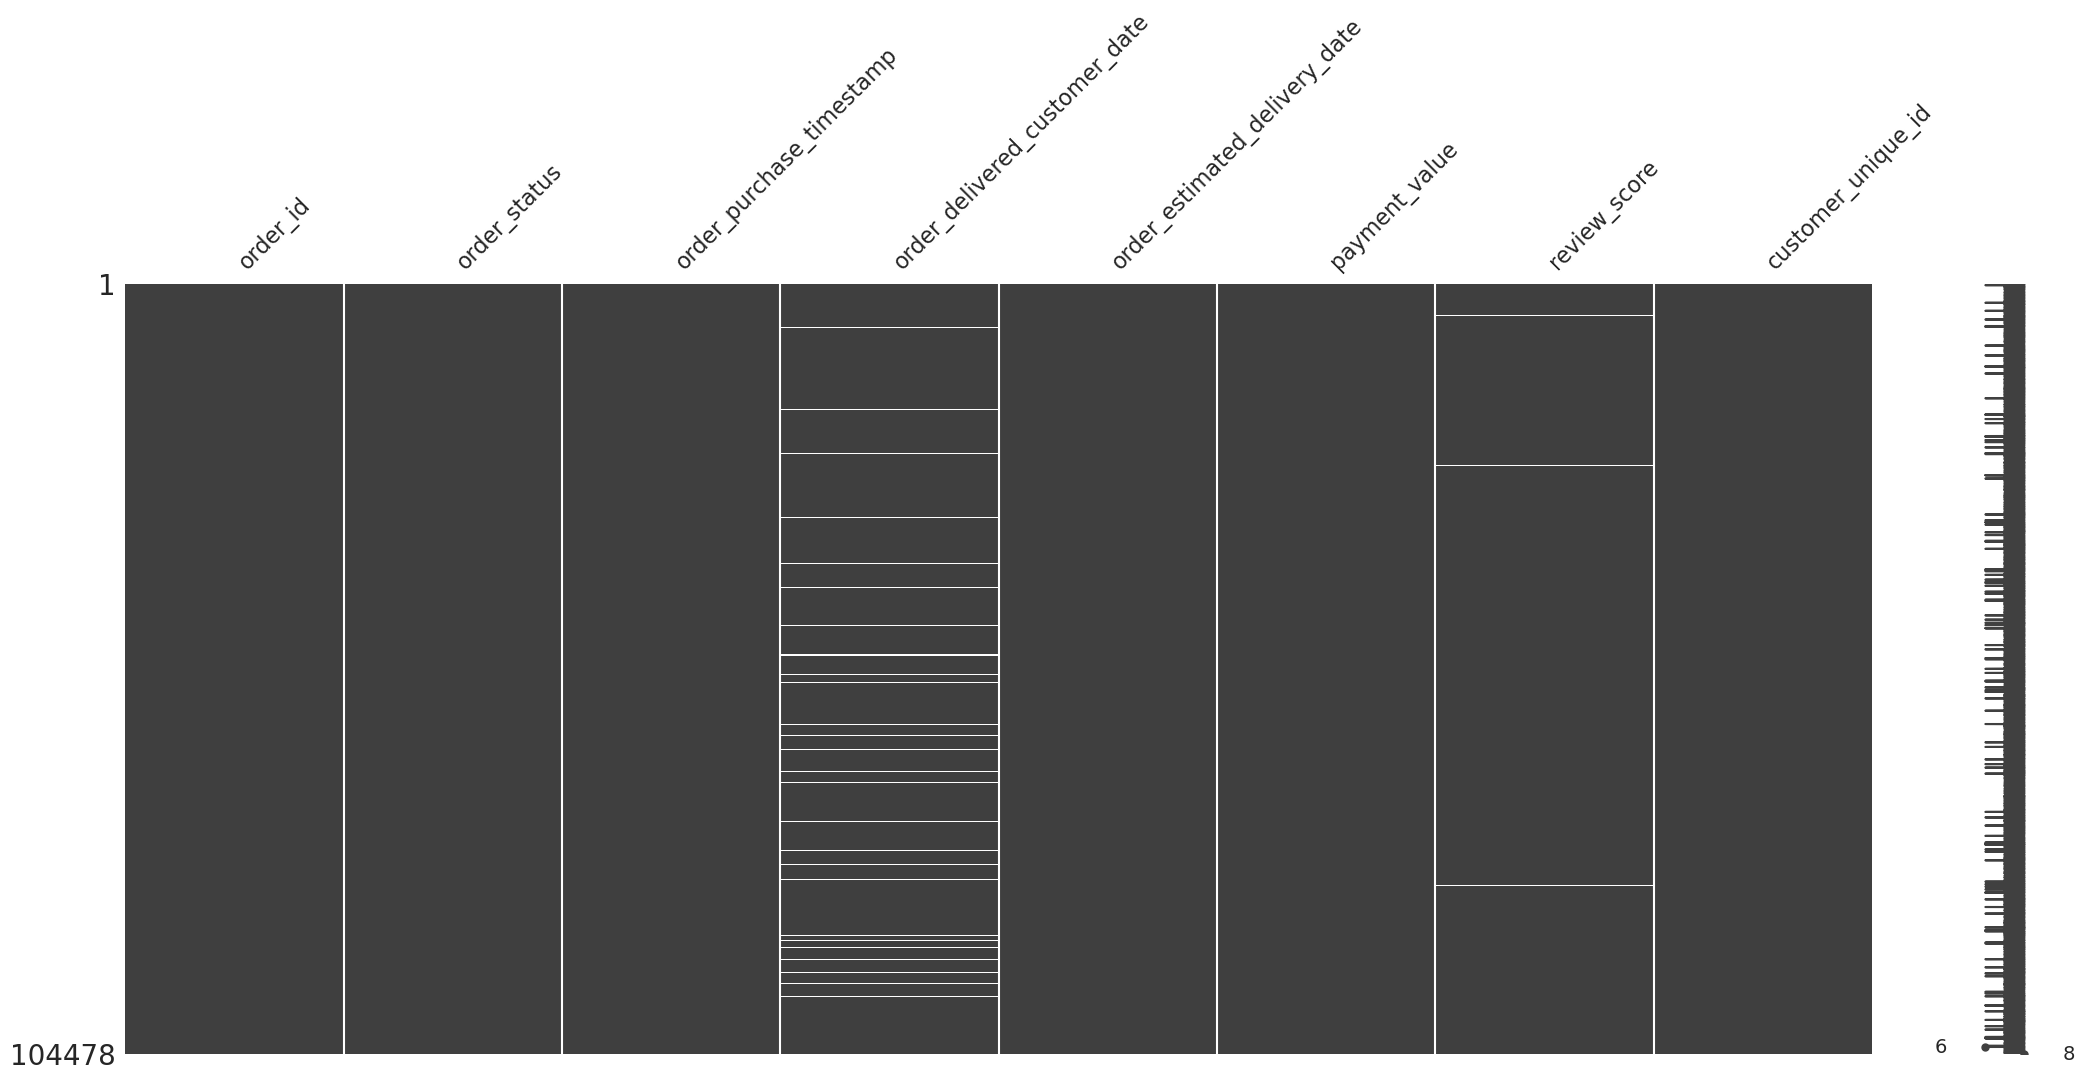

In [33]:
mno.matrix(df)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104478 entries, 0 to 104477
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       104478 non-null  object        
 1   order_status                   104478 non-null  object        
 2   order_purchase_timestamp       104478 non-null  datetime64[ns]
 3   order_delivered_customer_date  101324 non-null  datetime64[ns]
 4   order_estimated_delivery_date  104478 non-null  datetime64[ns]
 5   payment_value                  104477 non-null  float64       
 6   review_score                   103678 non-null  float64       
 7   customer_unique_id             104478 non-null  object        
dtypes: datetime64[ns](3), float64(2), object(3)
memory usage: 6.4+ MB


### Orders analysis

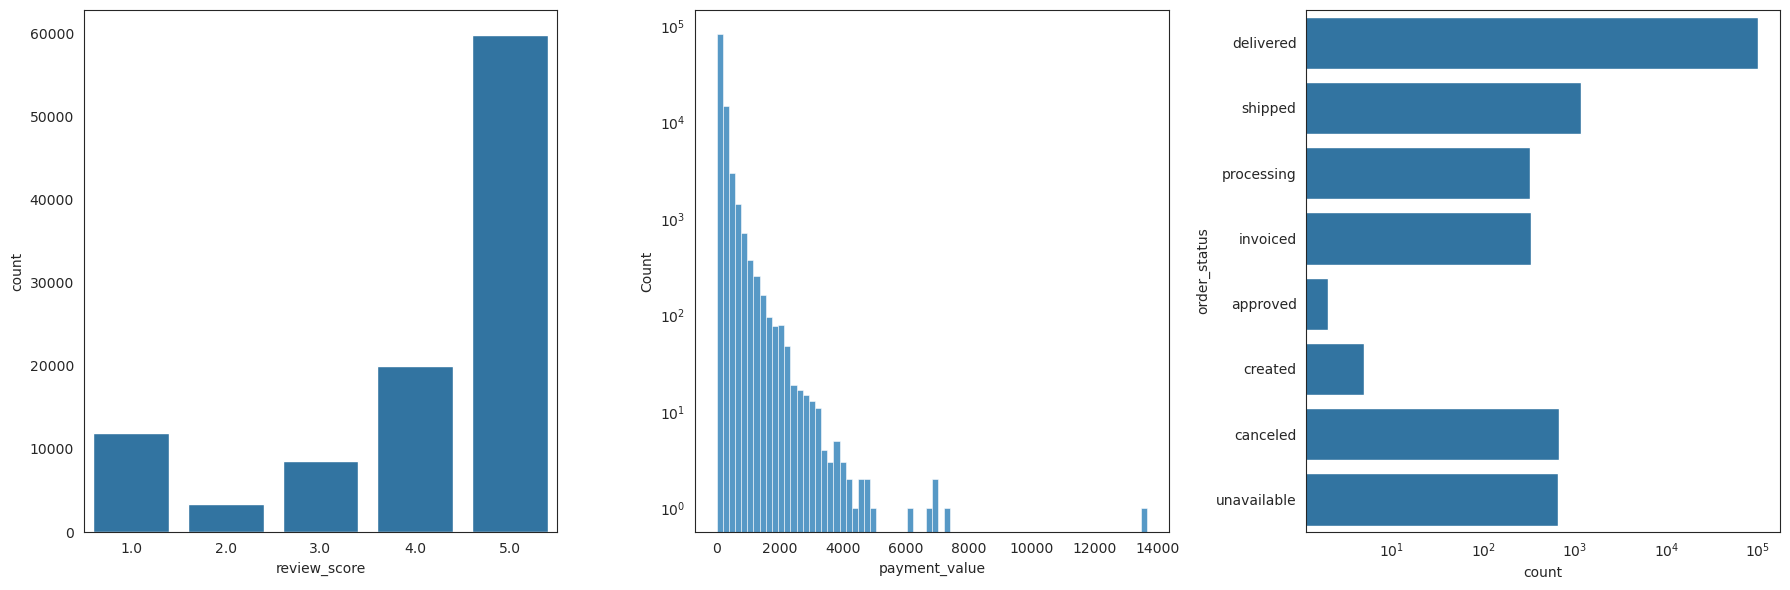

In [35]:
fig = plt.figure(figsize=(18, 6))

fig.add_subplot(131)
sns.countplot(data=df, x="review_score")

fig.add_subplot(132)
sns.histplot(data=df, x="payment_value", bins=70)
plt.yscale("log")

fig.add_subplot(133)
sns.countplot(
    data=df,
    y="order_status",
    order=[
        "delivered",
        "shipped",
        "processing",
        "invoiced",
        "approved",
        "created",
        "canceled",
        "unavailable",
    ],
)
plt.xscale("log")

plt.tight_layout()

# Feature Engineering

## Missing payment imputation

In [36]:
df.loc[df["payment_value"].isna(), "payment_value"] = 0

## Addtitional features

### Delay

In [37]:
NOW = df["order_purchase_timestamp"].value_counts().sort_index(ascending=False).index[0]

In [38]:
# Delay = time between the estimated delivery date and the actual delivery date
df["delay"] = df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]

# Delay = time between now and the estimated delivery date, or 0 if the estimated delivery date is in the future
delay_pending = (NOW - df["order_estimated_delivery_date"]).where(
    NOW - df["order_estimated_delivery_date"] > pd.Timedelta(0), pd.Timedelta(0)
)

# Mask for orders not yet delivered
mask_pending = pd.isnull(df["order_delivered_customer_date"])
df.loc[mask_pending, "delay"] = df["delay"].combine_first(delay_pending)

# Delay = 0 for canceled and unavailable orders
mask_canceled_unavailable = df["order_status"].isin(["canceled", "unavailable"])
df.loc[mask_canceled_unavailable, "delay"] = pd.Timedelta(0)

### Time since order

In [39]:
df["time_since_order"] = NOW - df["order_purchase_timestamp"]

In [40]:
df

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,payment_value,review_score,customer_unique_id,delay,time_since_order
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,18.12,4.0,7c396fd4830fd04220f754e42b4e5bff,-8 days +21:25:13,380 days 06:33:45
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,2.00,4.0,7c396fd4830fd04220f754e42b4e5bff,-8 days +21:25:13,380 days 06:33:45
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,18.59,4.0,7c396fd4830fd04220f754e42b4e5bff,-8 days +21:25:13,380 days 06:33:45
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,141.46,4.0,af07308b275d755c9edb36a90c618231,-6 days +15:27:45,84 days 20:48:41
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,179.12,5.0,3a653a41f6f9fc3d2a113cf8398680e8,-18 days +18:06:29,70 days 08:51:29
...,...,...,...,...,...,...,...,...,...,...
104473,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09 09:54:05,2017-03-17 15:08:01,2017-03-28,85.08,5.0,6359f309b166b0196dbf7ad2ac62bb5a,-11 days +15:08:01,587 days 07:36:13
104474,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,2018-02-28 17:37:56,2018-03-02,195.00,4.0,da62f9e57a76d978d02ab5362c509660,-2 days +17:37:56,253 days 04:31:20
104475,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,2017-09-21 11:24:17,2017-09-27,271.01,5.0,737520a9aad80b3fbbdad19b66b37b30,-6 days +11:24:17,416 days 02:43:35
104476,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-25 23:32:54,2018-02-15,441.16,2.0,5097a5312c8b157bb7be58ae360ef43c,-21 days +23:32:54,281 days 20:01:51


## Group by "order_id"

In [41]:
df_agg_order = (
    df.groupby("order_id")
    .agg(
        {
            "customer_unique_id": "first",
            "payment_value": "sum",
            "review_score": "mean",
            "time_since_order": "first",
            "delay": "max",

        }
    )
    .reset_index()
)

In [42]:
df_agg_order.columns = ["order_id", "customer_unique_id", "total_payments", "mean_review_score", "time_since_order", "delay"]

In [48]:
df_agg_order

,order_id,customer_unique_id,total_payments,mean_review_score,time_since_order,delay
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,72.19,5.0,399 days 08:31:16,-9 days +23:43:48
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,259.83,4.0,539 days 06:37:12,-3 days +16:04:24
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,216.87,5.0,276 days 02:56:47,-14 days +13:19:16
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,25.78,4.0,70 days 07:29:43,-6 days +13:32:39
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,218.04,5.0,620 days 03:32:27,-16 days +16:42:31
...,...,...,...,...,...,...
99436,fffc94f6ce00a00581880bf54a75a037,0c9aeda10a71f369396d0c04dce13a64,343.40,5.0,177 days 03:33:12,-8 days +22:56:40
99437,fffcd46ef2263f404302a634eb57f7eb,0da9fe112eae0c74d3ba1fe16de0988b,386.53,5.0,95 days 07:03:32,-9 days +20:31:55
99438,fffce4705a9662cd70adb13d4a31832d,cd79b407828f02fdbba457111c38e4c4,116.85,5.0,359 days 00:22:22,-13 days +12:22:22
99439,fffe18544ffabc95dfada21779c9644f,eb803377c9315b564bdedad672039306,64.71,5.0,428 days 18:27:19,-9 days +21:59:40


In [22]:
df_agg_order.to_json('orders.json')

## Group by "customer_id"

In [ ]:
csum = CustomerSummary()
df_agg_customer = csum.fit_transform(df_agg_order)

In [ ]:
df_agg_customer

,n_orders,total_payments,mean_review_score,time_since_order,mean_delay
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,5.0,160 days 06:33:51,-5 days +20:48:37
0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,4.0,163 days 06:18:51,-5 days +18:02:42
0000f46a3911fa3c0805444483337064,1,86.22,3.0,585 days 20:25:15,-2 days +14:38:47
0000f6ccb0745a6a4b88665a16c9f078,1,43.62,4.0,369 days 21:00:37,-12 days +21:23:05
0004aac84e0df4da2b147fca70cf8255,1,196.89,5.0,336 days 21:44:36,-8 days +23:08:56
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,2067.42,5.0,495 days 20:29:42,-27 days +09:22:00
fffea47cd6d3cc0a88bd621562a9d061,1,84.58,4.0,310 days 21:22:22,-3 days +22:28:20
ffff371b4d645b6ecea244b27531430a,1,112.46,5.0,617 days 01:41:02,-30 days +12:45:04


## Imputation and standardization

In [ ]:
cstd = CustomerStandardizer()
df_std = cstd.fit_transform(df_agg_customer)

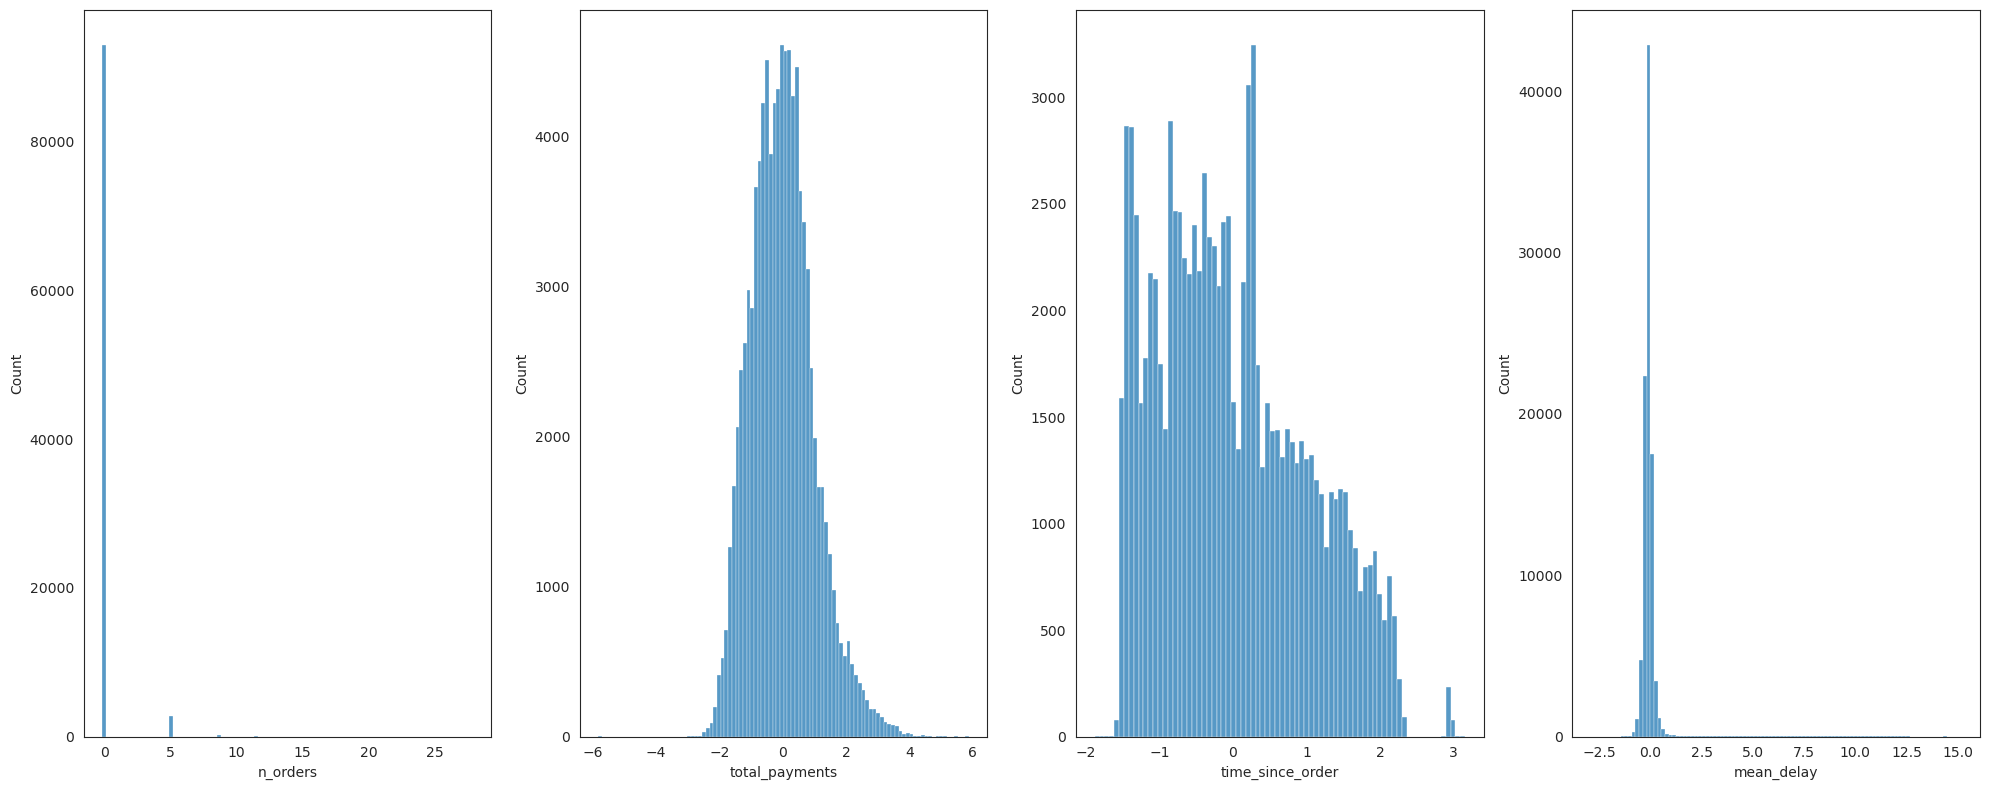

In [ ]:
fig = plt.figure(figsize=(20,8))

fig.add_subplot(141)
sns.histplot(df_std["n_orders"], bins=100)

fig.add_subplot(142)
sns.histplot(df_std["total_payments"], bins=100)

fig.add_subplot(143)
sns.histplot(df_std["time_since_order"])

fig.add_subplot(144)
sns.histplot(df_std["mean_delay"], bins=100)

plt.tight_layout()

In [ ]:
df_std

,n_orders,total_payments,mean_review_score,time_since_order,mean_delay
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.173593,0.278509,0.684576,-0.833865,0.025207
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.173593,-1.715381,-0.063565,-0.814378,0.022821
0000f46a3911fa3c0805444483337064,-0.173593,-0.327960,-0.811705,1.940152,0.082023
0000f6ccb0745a6a4b88665a16c9f078,-0.173593,-1.151287,-0.063565,0.532372,-0.119279
0004aac84e0df4da2b147fca70cf8255,-0.173593,0.678430,0.684576,0.317469,-0.034910
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,-0.173593,3.561242,0.684576,1.353531,-0.440327
fffea47cd6d3cc0a88bd621562a9d061,-0.173593,-0.351277,-0.063565,0.147894,0.068065
ffff371b4d645b6ecea244b27531430a,-0.173593,-0.004874,0.684576,2.143647,-0.499541


In [ ]:
df_std.to_json('data.json')